In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text # Not used directly but needed to import TF ops.

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dot, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from scipy.spatial.distance import cosine
from tqdm import tqdm

In [2]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("TF version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)

Numpy version:  1.18.2
Pandas version:  1.0.3
TF version:  2.1.0
TF-Hub version:  0.8.0


In [3]:
df = pd.read_parquet('data/QA_bin.parquet'); df.head()

,Question,Answer,isAnswer
0,"Новые вакансии в <http://comma.ai|comma.ai>, в...",А обязательно приводить к одному размеру? Оно ...,0
1,"Что думаете, будет шейкап?",<@U4B8MC0AD> Насколько я помню там предлагаютс...,0
2,Там главное всех unfollow нахер,Мало-мало человек фолловлю,1
3,На recsys2017 кто-нибудь поехал?,и рандомщиков! =) ибо потом можно прорешать и ...,0
4,"Друг говорит, что на запрос инвайта нет ответа...",Еще набор утверждений:\n1) такой проблемы с по...,0


In [4]:
path_to_model = "models/USE_mul3"

USE tests

Смотрим, чё вообще этот юз может и прикидываем более керасный способ считать косинусное расстояние

In [5]:
use = hub.KerasLayer(path_to_model, trainable=True, input_shape=(1,), dtype=tf.string)
u = use(df.loc[0, ['Question', 'Answer']])
print(f'Shape: {u.shape}')
print(cosine(u[0], u[1]))
print(tf.reshape(1+tf.keras.losses.CosineSimilarity()(u[0], u[1]), (1,)))
q = use(df.loc[0, 'Question'])
a = use(df.loc[0, 'Answer'])
print(1 - Dot(1, normalize=True)([q, a]))

Shape: (2, 512)
0.9680848121643066
tf.Tensor([0.9680848], shape=(1,), dtype=float32)
tf.Tensor([[0.9680848]], shape=(1, 1), dtype=float32)


Строим модельку

In [5]:
question = Input(shape=(1,), dtype=tf.string, name='Question')
answer = Input(shape=(1,), dtype=tf.string, name='Answer')
use = hub.KerasLayer(path_to_model, trainable=True, name='USE')
q_emb = use(tf.squeeze(tf.cast(question, tf.string)))
a_emb = use(tf.squeeze(tf.cast(answer, tf.string)))
cos_dist = 1 - Dot(1, normalize=True, name='Cosine')([q_emb, a_emb])
pred = Dense(2, activation='softmax')(cos_dist)
model = Model(inputs=[question, answer], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Question (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Answer (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [None]               0           Question[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Squeeze_1 (TensorFl [None]               0           Answer[0][0]                     
______________________________________________________________________________________________

### Разбиваем данные на три части

In [4]:
df['y_0'] = np.nan
df['y_1'] = np.nan
df.loc[:, ['y_0', 'y_1']] = to_categorical(df['isAnswer'])
df.head()

,Question,Answer,isAnswer,y_0,y_1
0,"Новые вакансии в <http://comma.ai|comma.ai>, в...",А обязательно приводить к одному размеру? Оно ...,0,1.0,0.0
1,"Что думаете, будет шейкап?",<@U4B8MC0AD> Насколько я помню там предлагаютс...,0,1.0,0.0
2,Там главное всех unfollow нахер,Мало-мало человек фолловлю,1,0.0,1.0
3,На recsys2017 кто-нибудь поехал?,и рандомщиков! =) ибо потом можно прорешать и ...,0,1.0,0.0
4,"Друг говорит, что на запрос инвайта нет ответа...",Еще набор утверждений:\n1) такой проблемы с по...,0,1.0,0.0


In [5]:
train, test = train_test_split(df, test_size=0.2, stratify=df['isAnswer'])
X_train, X_valid, y_train, y_valid = train_test_split(train.loc[:, ['Question', 'Answer']], train.loc[:, ['y_0', 'y_1']],
                                                      test_size=0.2, stratify=train['isAnswer'])
X_test, y_test = test.loc[:, ['Question', 'Answer']], test['isAnswer']

Как работает моделька без обучения

In [11]:
score, acc = model.evaluate([X_test['Question'], X_test['Answer']], test.loc[:, ['y_0', 'y_1']], batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

264114/264114 [==============================] - 4214s 16ms/sample - loss: 0.7116 - accuracy: 0.4907
Test score: 0.7115747847483732
Test accuracy: 0.49070477


### Учим

In [6]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [7]:
model = tf.keras.models.load_model('models/USE_training.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [8]:
# update the learning rate
print("[INFO] old learning rate: {}".format(
    tf.keras.backend.get_value(model.optimizer.lr)))
tf.keras.backend.set_value(model.optimizer.lr, model.optimizer.lr*1e-2)
print("[INFO] new learning rate: {}".format(
    tf.keras.backend.get_value(model.optimizer.lr)))

[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 1.0000000656873453e-05


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/USE_training.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
reduse_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto',
                                                 min_delta=0.001, cooldown=0, min_lr=0.0000001)

train_hist = model.fit([X_train['Question'], X_train['Answer']], y_train,
                 batch_size=512,
                 epochs=20,
                 validation_data=([X_valid['Question'], X_valid['Answer']], y_valid),
                 callbacks=[early_stopping, checkpoint, reduse_lr])

Train on 845164 samples, validate on 211292 samples
Epoch 1/20
844800/845164 [============================>.] - ETA: 5s - loss: 0.6399 - accuracy: 0.6299
Epoch 00001: val_loss improved from inf to 0.63822, saving model to models/USE_training.h5
845164/845164 [==============================] - 13651s 16ms/sample - loss: 0.6399 - accuracy: 0.6299 - val_loss: 0.6382 - val_accuracy: 0.6342
Epoch 2/20
844800/845164 [============================>.] - ETA: 6s - loss: 0.6382 - accuracy: 0.6326
Epoch 00002: val_loss improved from 0.63822 to 0.63710, saving model to models/USE_training.h5
845164/845164 [==============================] - 14928s 18ms/sample - loss: 0.6382 - accuracy: 0.6326 - val_loss: 0.6371 - val_accuracy: 0.6356
Epoch 3/20
844800/845164 [============================>.] - ETA: 5s - loss: 0.6370 - accuracy: 0.6341
Epoch 00003: val_loss improved from 0.63710 to 0.63634, saving model to models/USE_training.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000656873

In [12]:
train_hist.history

{'loss': [0.6398639580895196,
  0.6381654031132009,
  0.636998802886258,
  0.6362664975995804,
  0.6361789139436662,
  0.6361673990507782,
  0.6361568435762741,
  0.6361467821127368,
  0.6361372965019858,
  0.6361275778200944,
  0.6361186317130317,
  0.6361103016796408,
  0.63610172473541,
  0.6360936424825651,
  0.6360858273294253,
  0.6360781530176511,
  0.6360703959999928,
  0.6360631126140198,
  0.6360559396463347,
  0.6360488451203492],
 'accuracy': [0.6299073,
  0.6326216,
  0.6340994,
  0.6353323,
  0.635427,
  0.6354352,
  0.6354483,
  0.63545775,
  0.63546246,
  0.63547665,
  0.6354743,
  0.635498,
  0.6355098,
  0.63554054,
  0.6355749,
  0.635582,
  0.63559383,
  0.6355867,
  0.63560206,
  0.6356139],
 'val_loss': [0.6382230842278014,
  0.6370970979655924,
  0.63633798752893,
  0.6362550190967267,
  0.6362471484039796,
  0.636240281998099,
  0.6362333762860791,
  0.6362268058362224,
  0.6362216432477819,
  0.6362154067252095,
  0.6362105025153383,
  0.6362046128761591,
  0.6

In [14]:
train_hist.params

{'batch_size': 512,
 'epochs': 20,
 'steps': 1651,
 'samples': 845164,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [10]:
y_preds = np.argmax(model.predict([X_test['Question'], X_test['Answer']]), axis=1)
print(metrics.classification_report(y_test, y_preds))

precision    recall  f1-score   support

           0       0.60      0.85      0.70    134517
           1       0.73      0.41      0.52    129597

    accuracy                           0.63    264114
   macro avg       0.66      0.63      0.61    264114
weighted avg       0.66      0.63      0.61    264114



### Пытаемся облегчить себе жизнь

In [3]:
df = pd.read_parquet('data/QA_chosen.parquet'); df.head()

,Question,Answer,isAnswer
0,Вопрос спецам по CV . Почему Residual blocks в...,"Это объясняется чуть меньше, чем везде",1
1,Вопрос спецам по CV . Почему Residual blocks в...,Начиная с оригинальной статьи про resnet,1
2,Вопрос спецам по CV . Почему Residual blocks в...,вот why resnet work <https://www.coursera.org/...,1
3,Вопрос спецам по CV . Почему Residual blocks в...,Перекидывание параметров - это :100: из :100:,1
4,Вопрос спецам по CV . Почему Residual blocks в...,"Я не то имела ввиду, мой корявый перевод с анг...",1


In [3]:
model = tf.keras.models.load_model('models/USE_training.h5', custom_objects={'KerasLayer':hub.KerasLayer})

In [5]:
preds = np.argmax(model.predict([df['Question'], df['Answer']]), axis=1)

In [7]:
df['USE_ans'] = preds; df.head()

,Question,Answer,isAnswer,USE_ans
0,Вопрос спецам по CV . Почему Residual blocks в...,"Это объясняется чуть меньше, чем везде",1,1
1,Вопрос спецам по CV . Почему Residual blocks в...,Начиная с оригинальной статьи про resnet,1,1
2,Вопрос спецам по CV . Почему Residual blocks в...,вот why resnet work <https://www.coursera.org/...,1,1
3,Вопрос спецам по CV . Почему Residual blocks в...,Перекидывание параметров - это :100: из :100:,1,1
4,Вопрос спецам по CV . Почему Residual blocks в...,"Я не то имела ввиду, мой корявый перевод с анг...",1,1


In [15]:
print(f'Full {len(df)}')
print(f"Use found {len(df[(df['isAnswer'] == 1) & (df['USE_ans'] == 1)])}")
print(f"{((len(df[(df['isAnswer'] == 1) & (df['USE_ans'] == 1)])*100)/len(df))} persents right")

Full 150517
Use found 60013
39.871243779772385 persents right


### Для кластеризации

In [3]:
import numpy as np
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
import pickle

### Получение эмбеддингов всех вопросов

In [4]:
model = tf.keras.models.load_model('models/USE_training.h5', custom_objects={'KerasLayer':hub.KerasLayer})
use = model.layers[4]

In [45]:
df = pd.read_parquet('data/QA_ODS_mod.parquet').dropna(); df.head()

,channel,ThreadStarter,Question,Answers,reply_count,thread_ts
0,lang_go,U64GCA997,"Народ, кто знает, есть ли в GO библиотека для ...","<BOA>В python. Аналог pandas есть только в R, ...",5,1549648499.004600
1,lang_go,U0FEJNBGQ,"чо как, ml стало легче тут использовать?",<BOA>Деплоить тф модели относительно easy и по...,3,1574626852.009300
2,lang_go,U64GCA997,"Народ, какие у вам задавали вопросы на собесе ...",<BOA>Как насчет дженериков? :kekeke:<EOA><BOA>...,7,1575315642.018100
3,lang_go,U7KHK3TTP,"Блин, а это что за шляпа такая? `CGO_LDFLAGS_A...","<BOA>Стоило написать, сразу нашел\n<https://gi...",1,1534807275.000100
4,lang_go,U3B7T7V8W,Подскажите как вот эту штуку покрасивее сделат...,"<BOA>есть вариант, вызывать эти `go Action` в...",1,1538993224.000100


### Получаем эмбеддинги предобученным USE для наиболее чистых вопросов

In [4]:
path_to_model = "models/USEm_large3"
use = hub.KerasLayer(path_to_model)

In [5]:
df = pd.read_parquet('data/qa_clean.parquet'); df.head()

,channel,question,answer,reactions
0,lang_go,"Всем привет, нуждаюсь в помощи по составлению ...",> в проект Data Science\nвыглядит как bullshit...,"[{'name': '+1', 'count': 1}]"
1,lang_go,"и еще вопрос, нет ли веяний, что этот проект п...",JetBrains по итогам своего исследования посчит...,"[{'name': 'tnx', 'count': 1}, {'name': '+1', '..."
2,lang_go,Кто-нибудь здесь проходил\n<http://coursera.or...,"если говорить про идеоматичность, то я обычно ...","[{'name': '+1::skin-tone-2', 'count': 2}]"
3,proj_kaggle_quest_challenge,"Ahh folks, anyone is able to submit an lstm+en...",Fixed this!,"[{'name': '+1', 'count': 3}]"
4,proj_kaggle_quest_challenge,Not sure but if people use embeddings for let'...,For these variables I save a dictionary/encodi...,"[{'name': '+1', 'count': 1}]"


In [6]:
df.drop_duplicates('question', inplace=True)

In [7]:
clusters = []
embs = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    clusters.append(row['channel'])
    embs.append(use(row['question']).numpy())

100%|██████████| 10969/10969 [11:11<00:00, 16.34it/s]


In [8]:
e = []
for emb in embs:
    e.append(emb.squeeze())
embs = np.vstack(e)
del df
del use

In [9]:
import pickle
with open('data/embs.pkl', 'wb') as f:
    pickle.dump(embs, f)
with open('data/clusters.pkl', 'wb') as f:
    pickle.dump(clusters, f)

### Снижение размерности

In [4]:
import pickle
with open('data/embs.pkl', 'rb') as f:
    embs = pickle.load(f)
with open('data/clusters.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [10]:
from sklearn.manifold import TSNE

embs_flat = TSNE(n_components=2, n_jobs=-1).fit_transform(embs)

In [11]:
embs_flat.shape

(10969, 2)

In [12]:
with open('data/embs_flat.pkl', 'wb') as f:
    pickle.dump(embs_flat, f)

### Кластеризация

In [27]:
with open('data/embs_flat.pkl', 'rb') as f:
    embs = pickle.load(f)
with open('data/clusters.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [28]:
# create clustering algorithms
dbscan   = cluster.DBSCAN(eps=.5, n_jobs=-1)
optics = cluster.OPTICS(min_samples=5, cluster_method='dbscan', n_jobs=-1)
birch    = cluster.Birch(n_clusters=len(set(clusters)))
means    = cluster.MiniBatchKMeans(n_clusters=len(set(clusters)))
spectral = cluster.SpectralClustering(n_clusters=len(set(clusters)), eigen_solver='arpack', affinity="nearest_neighbors", n_jobs=-1)
affinity = cluster.AffinityPropagation(damping=.9, preference=-200)

# change here, to select clustering algorithm (note: spectral is slow)
algorithm = means  # <- SELECT ALG

# predict cluster memberships
algorithm.fit(embs)
if hasattr(algorithm, 'labels_'):
    labels = algorithm.labels_.astype(np.int)
else:
    labels = algorithm.predict(X)

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(clusters)
labels_true = le.transform(clusters)

In [30]:
from sklearn import metrics

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(embs, labels))

Estimated number of clusters: 208
Estimated number of noise points: 0
Homogeneity: 0.413
Completeness: 0.293
V-measure: 0.343
Adjusted Rand Index: 0.033
Adjusted Mutual Information: 0.217
Silhouette Coefficient: 0.326


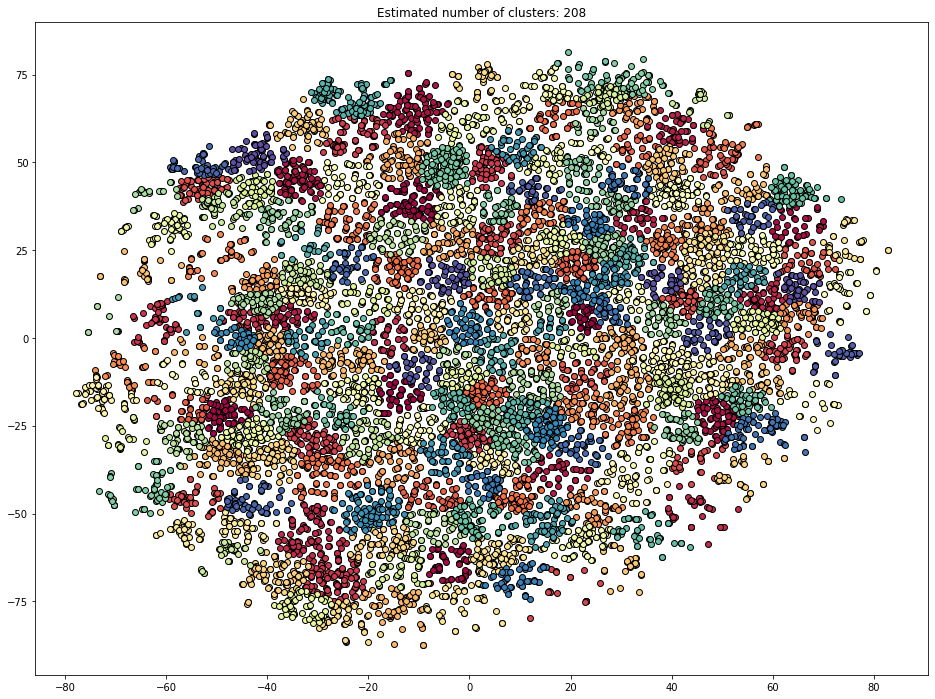

In [31]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(16,12))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embs[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [32]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource

In [33]:
from bokeh.palettes import Turbo256

Turbo256[0]

'#30123b'

In [34]:
df = pd.read_parquet('data/qa_clean.parquet').drop_duplicates('question')

In [35]:
quests = df['question'].to_numpy()

In [36]:
palette = [Turbo256[each]
          for each in np.linspace(0, 255, num=len(unique_labels), dtype=np.int)]
colors = []
for cl in labels:
    colors.append(Turbo256[cl])

In [37]:
PLOT_SIZE = 1000

source = ColumnDataSource(data=dict(
    x=embs[:, 0],
    y=embs[:, 1],
    colors=colors,
    quests=list(quests),
    clusters = clusters
))

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("cluster", "@clusters"),
    ("question", "@quests"),
]

p = figure(output_backend="webgl", title=algorithm.__class__.__name__,
            plot_width=PLOT_SIZE, plot_height=PLOT_SIZE, tooltips=TOOLTIPS)

p.scatter('x', 'y', color='colors', source=source)

output_file("clustering.html", title="clustering with sklearn")

show(p)

### Кластеризация с помощью модуля

In [3]:
from modules.clustering import make_clusters

In [4]:
path_to_model = "models/USEm_large3"
use = hub.KerasLayer(path_to_model)

In [5]:
df = pd.read_parquet('data/qa_clean.parquet').drop_duplicates('answer')

In [6]:
help(make_clusters)

Help on function make_clusters in module clustering:

make_clusters(model, texts, labels, algorithm='kmeans', dims=2, plot_path='', plot_name='clustering.html', plot_size=1000, plot_title='Embeddings clusters')
    Computes embeddings and plot clusters of them.
    Parameters
    ----------
    model : the embedder model
    texts : list
            A list of texts corresponding to the embeddings
    clusters : list
               A list of true clusters
    algorithm : string, optional
                A name of clustering algorithm
    plot_path : int, optional
                A path to output plot
    plot_name : int, optional
                A name of output plot
    plot_size : int, optional
                A size of output plot
    plot_title : string, optional
                 A title of output plot



In [7]:
make_clusters(use, df['answer'].to_numpy(), df['channel'].to_numpy(), plot_name='anwers_clusters.html', plot_title='Answers clusters')

100%|██████████| 17567/17567 [14:30<00:00, 20.19it/s]
Redusing dimensionality from 512 to 2
Estimated number of clusters: 208
Estimated number of noise points: 0
Homogeneity: 0.269
Completeness: 0.184
V-measure: 0.219
Adjusted Rand Index: 0.013
Adjusted Mutual Information: 0.116
Silhouette Coefficient: 0.296
